<a href="https://colab.research.google.com/github/akhilsrinath/soccer-analytics/blob/main/Soccer_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Extraction & Transformation**

Parsing and extracting raw data from StatsBomb and storing it in a Pandas DataFrame. 

In [1]:
import requests 
import pandas as pd 
import tqdm as tqdm 
import matplotlib.pyplot as plt

- requests: executing HTTP requests 
- pandas: data analysis and manipulation 
- tqdm: progress bar

In [2]:
## Locations for the raw statsbomb data 

base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"


In [3]:
def parse_data(competition_id, season_id):
  matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
  match_ids = [m['match_id'] for m in matches]

  all_events = []
  for match_id in match_ids: 
    events = requests.get(url=match_url.format(match_id)).json()

    shots = [x for x in events if x['type']['name'] == 'Shot']
    for s in shots:
      attributes = {
          'match_id': match_id,
          'team': s['possession_team']['name'],
          'player': s['player']['name'],
          'x': s['location'][0],
          'y': s['location'][1],
          'outcome': s['shot']['outcome']['name'],
      }
      all_events.append(attributes)

  return pd.DataFrame(all_events)

In [4]:
competition_id = 43
season_id = 3

In [5]:
df = parse_data(competition_id, season_id)

In [6]:
df.head(10)

,match_id,team,player,x,y,outcome
0,7578,Uruguay,Edinson Roberto Cavani Gómez,97.0,32.0,Saved
1,7578,Egypt,Mahmoud Ibrahim Hassan,108.0,51.0,Saved
2,7578,Uruguay,Luis Alberto Suárez Díaz,109.0,55.0,Off T
3,7578,Uruguay,Edinson Roberto Cavani Gómez,102.0,23.0,Blocked
4,7578,Uruguay,José Martín Cáceres Silva,114.0,48.0,Wayward
5,7578,Uruguay,Luis Alberto Suárez Díaz,116.0,35.0,Off T
6,7578,Egypt,Marwan Mohsen,100.0,51.0,Saved
7,7578,Uruguay,Matías Vecino Falero,83.0,53.0,Off T
8,7578,Uruguay,Luis Alberto Suárez Díaz,88.0,38.0,Blocked
9,7578,Egypt,Abdalla Mahmoud El Said Bekhit,105.0,48.0,Wayward


## **Linear Regression**

#### Examining the relationship between a player's pass volume and completion percentage. 

In [7]:
def parse_pass_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in match_ids:

        events = requests.get(url=match_url.format(match_id)).json()
        passes = [x for x in events if x['type']['name'] == "Pass"]
        
        for a in passes:
            attributes = {
                "player_id": a['player']['id'],
                "outcome": 0 if 'outcome' in a['pass'].keys() else 1,
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

In [8]:
competition_id = 43
season_id = 3
pass_df = parse_pass_data(competition_id, season_id)

In [9]:
pass_df.head(15)

,player_id,outcome
0,4319,1
1,5259,0
2,5263,0
3,5255,0
4,5255,1
5,5259,1
6,5249,1
7,5255,1
8,5249,1
9,5260,1


In [10]:
total_passes = pass_df.groupby('player_id')['outcome'].sum()
percentage = pass_df.groupby('player_id')['outcome'].mean()

In [11]:
total_passes

player_id
2941      50
2948      28
2954      98
2974      32
2995      60
        ... 
19597     30
19988      3
20004    244
20005    398
20016    131
Name: outcome, Length: 600, dtype: int64

Let us now look at the relationship between the pass volume and the pass completion percentage for the players in the dataset. 

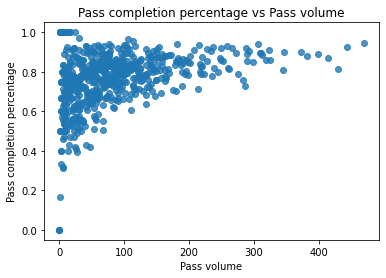

In [15]:
plt.scatter(total_passes, percentage, alpha=0.8)
plt.xlabel("Pass volume")
plt.ylabel("Pass completion percentage")
plt.title("Pass completion percentage vs Pass volume")
plt.show()

#### Building a simple regression model

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
fit = model.fit([[x] for x in total_passes], percentage)
print("Coefficients: {}".format(fit.coef_))
print("Intercept: {}".format(fit.intercept_))

Coefficients: [0.00063207]
Intercept: 0.7094185597471281


In [28]:
xfit = [0, 500] # This is the x-axis range of the chart
yfit = model.predict([[x] for x in xfit])

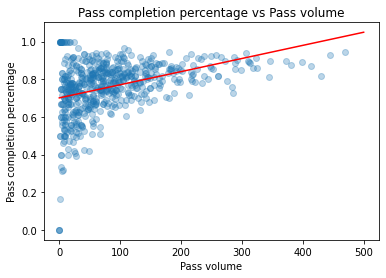

In [30]:
plt.scatter(total_passes, percentage, alpha=0.3)
plt.plot(xfit, yfit, 'r')
plt.xlabel("Pass volume")
plt.ylabel("Pass completion percentage")
plt.title("Pass completion percentage vs Pass volume")
plt.show()